# Accuracy Benchmark

In [ ]:
!pip install pymatching beliefmatching stim

In [2]:
import pathlib
import time
import yaml
import math
from concurrent.futures import ProcessPoolExecutor
import numpy as np
import stim
import pymatching
import beliefmatching
import matplotlib.pyplot as plt

In [3]:
data_dir = pathlib.Path("/home/inm/WorkDir/QEC/paper_data/google_qec3v5_experiment_data/")

## Google's baseline

In [4]:
# select a single d=3 patch
d3_center = "5_7"
all_d3_subdir = [
    x for x in data_dir.iterdir()
    if x.is_dir() and f"d3" in x.name and "bX" in x.name and d3_center in x.name
]
all_d3_subdir = sorted(all_d3_subdir, key=lambda x: int(x.name.split('_')[4][1:]))
assert len(all_d3_subdir) == 13
# d=5
all_d5_subdir = [
    x for x in data_dir.iterdir()
    if x.is_dir() and f"d5" in x.name and "bX" in x.name
]
all_d5_subdir = sorted(all_d5_subdir, key=lambda x: int(x.name.split('_')[4][1:]))
assert len(all_d5_subdir) == 13

all_rounds = list(range(1, 26, 2))

In [5]:
def get_google_baseline(dirs):
    results = {"pymatching": [], "correlated": [], "belief_matching": [], "tensor_network_contraction": []}
    for sub_dir in dirs:
        actual_flips = stim.read_shot_data_file(path=sub_dir / "obs_flips_actual.01", format="01", num_observables=1)
        pymatching_predictions = stim.read_shot_data_file(path=sub_dir / "obs_flips_predicted_by_pymatching.01", format="01", num_observables=1)
        correlated_predictions = stim.read_shot_data_file(path=sub_dir / "obs_flips_predicted_by_correlated_matching.01", format="01", num_observables=1)
        belief_matching_predictions = stim.read_shot_data_file(path=sub_dir / "obs_flips_predicted_by_belief_matching.01", format="01", num_observables=1)
        tensor_network_predictions = stim.read_shot_data_file(path=sub_dir / "obs_flips_predicted_by_tensor_network_contraction.01", format="01", num_observables=1)
        results["pymatching"].append(1 - 2 * (actual_flips ^ pymatching_predictions).mean())
        results["correlated"].append(1 - 2 * (actual_flips ^ correlated_predictions).mean())
        results["belief_matching"].append(1 - 2 * (actual_flips ^ belief_matching_predictions).mean())
        results["tensor_network_contraction"].append(1 - 2 * (actual_flips ^ tensor_network_predictions).mean())
    return results

In [6]:
d3_baseline = get_google_baseline(all_d3_subdir)
d5_baseline = get_google_baseline(all_d5_subdir)

## Benchmark

### Pymatching

In [7]:
def pymatching_decode(dirs):
    fidelities = []
    for sub_dir in dirs:
        with open(sub_dir / "properties.yml") as f:
            properties = yaml.load(f, Loader=yaml.SafeLoader)
        num_detectors = properties["circuit_detectors"]
        actual_flips = stim.read_shot_data_file(path=sub_dir / "obs_flips_actual.01", format="01", num_observables=1)
        detection_events = stim.read_shot_data_file(path=sub_dir / "detection_events.b8", format="b8", num_detectors=num_detectors)
        matching = pymatching.Matching.from_detector_error_model_file(str(sub_dir / "circuit_detector_error_model.dem"))
        predictions = matching.decode_batch(detection_events)
        # matching_even = pymatching.Matching.from_detector_error_model_file(str(sub_dir / "pij_from_odd_for_even.dem"))
        # matching_odd = pymatching.Matching.from_detector_error_model_file(str(sub_dir / "pij_from_even_for_odd.dem"))
        # even_predictions = matching_even.decode_batch(detection_events[::2])
        # odd_predictions = matching_odd.decode_batch(detection_events[1::2])
        # fidelity = 1 - 2 * ((even_predictions ^ actual_flips[::2]).sum() + (odd_predictions ^ actual_flips[1::2]).sum()) / len(actual_flips)
        fidelity = 1 - 2 * (predictions ^ actual_flips).mean()
        fidelities.append(fidelity)
    return fidelities
        
    

In [8]:
pymatching_fidelities_d3 = pymatching_decode(all_d3_subdir)
pymatching_fidelities_d5 = pymatching_decode(all_d5_subdir)


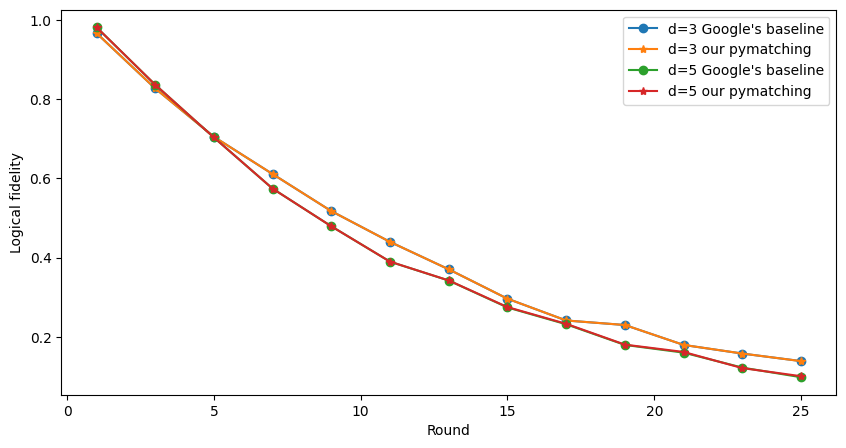

In [8]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(all_rounds, d3_baseline["pymatching"], label="d=3 Google's baseline", marker='o')
ax.plot(all_rounds, pymatching_fidelities_d3, label="d=3 our pymatching", marker='*')
ax.plot(all_rounds, d5_baseline["pymatching"], label="d=5 Google's baseline", marker='o')
ax.plot(all_rounds, pymatching_fidelities_d5, label="d=5 our pymatching", marker='*')
ax.set_xlabel("Round")
ax.set_ylabel("Logical fidelity")
ax.legend()




### Belief Matching

In [12]:
def decode(dem, detection_events):
    decoder = beliefmatching.BeliefMatching.from_detector_error_model(dem, max_bp_iters=5)
    return decoder.decode_batch(detection_events)

def parallel_decode(dem, detection_events):
    with ProcessPoolExecutor(max_workers=8) as executor:
        num_shots = len(detection_events)
        chunk_size = math.ceil(num_shots / 8)
        futures = [
            executor.submit(decode, dem, detection_events[i*chunk_size:min((i+1)*chunk_size, num_shots)])
            for i in range(8)
        ]
        results = np.concatenate([f.result() for f in futures])
    return results

In [13]:
def belief_matching_decode(dirs):
    fidelities = []
    for sub_dir in dirs:
        with open(sub_dir / "properties.yml") as f:
            properties = yaml.load(f, Loader=yaml.SafeLoader)
        start = time.perf_counter()
        num_detectors = properties["circuit_detectors"]
        actual_flips = stim.read_shot_data_file(path=sub_dir / "obs_flips_actual.01", format="01", num_observables=1)
        detection_events = stim.read_shot_data_file(path=sub_dir / "detection_events.b8", format="b8", num_detectors=num_detectors)
        dem_odd_for_even = stim.DetectorErrorModel.from_file(sub_dir / "pij_from_odd_for_even.dem")
        dem_even_for_odd = stim.DetectorErrorModel.from_file(sub_dir / "pij_from_even_for_odd.dem")
        even_predictions = parallel_decode(dem_odd_for_even, detection_events[::2])
        odd_predictions = parallel_decode(dem_even_for_odd, detection_events[1::2])
        fidelity = 1 - 2 * ((even_predictions ^ actual_flips[::2]).sum() + (odd_predictions ^ actual_flips[1::2]).sum()) / len(actual_flips)
        fidelities.append(fidelity)
        print(f"{sub_dir.name} takes {time.perf_counter() - start:.2f}s")
    return fidelities

In [14]:
beliefmatching_fidelities_d3 = belief_matching_decode(all_d3_subdir)
beliefmatching_fidelities_d5 = belief_matching_decode(all_d5_subdir)

surface_code_bX_d3_r01_center_5_7 takes 0.44s
surface_code_bX_d3_r03_center_5_7 takes 0.79s
surface_code_bX_d3_r05_center_5_7 takes 1.25s
surface_code_bX_d3_r07_center_5_7 takes 1.92s
surface_code_bX_d3_r09_center_5_7 takes 2.55s
surface_code_bX_d3_r11_center_5_7 takes 3.14s
surface_code_bX_d3_r13_center_5_7 takes 3.86s
surface_code_bX_d3_r15_center_5_7 takes 4.38s
surface_code_bX_d3_r17_center_5_7 takes 5.15s
surface_code_bX_d3_r19_center_5_7 takes 5.92s
surface_code_bX_d3_r21_center_5_7 takes 6.17s
surface_code_bX_d3_r23_center_5_7 takes 6.75s
surface_code_bX_d3_r25_center_5_7 takes 7.31s
surface_code_bX_d5_r01_center_5_5 takes 0.42s
surface_code_bX_d5_r03_center_5_5 takes 2.60s
surface_code_bX_d5_r05_center_5_5 takes 5.02s
surface_code_bX_d5_r07_center_5_5 takes 6.98s
surface_code_bX_d5_r09_center_5_5 takes 10.17s
surface_code_bX_d5_r11_center_5_5 takes 12.05s
surface_code_bX_d5_r13_center_5_5 takes 13.97s
surface_code_bX_d5_r15_center_5_5 takes 16.25s
surface_code_bX_d5_r17_center_

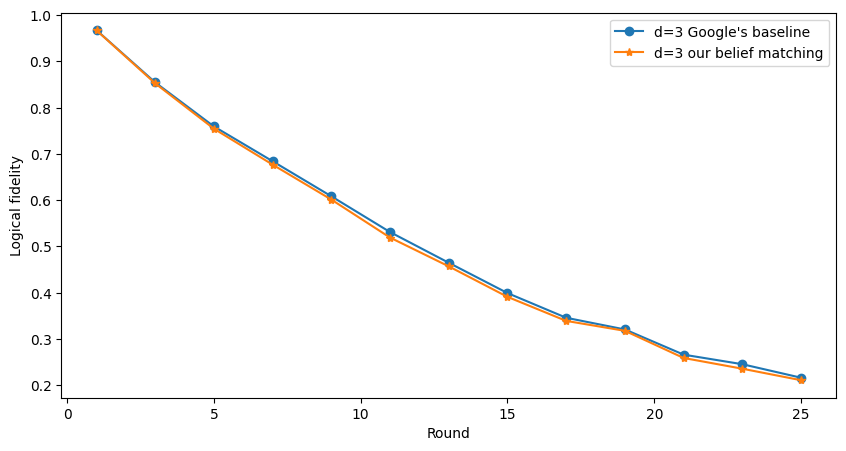

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(all_rounds, d3_baseline["belief_matching"], label="d=3 Google's baseline", marker='o')
ax.plot(all_rounds, beliefmatching_fidelities_d3, label="d=3 our belief matching", marker='*')
ax.set_xlabel("Round")
ax.set_ylabel("Logical fidelity")
ax.legend()

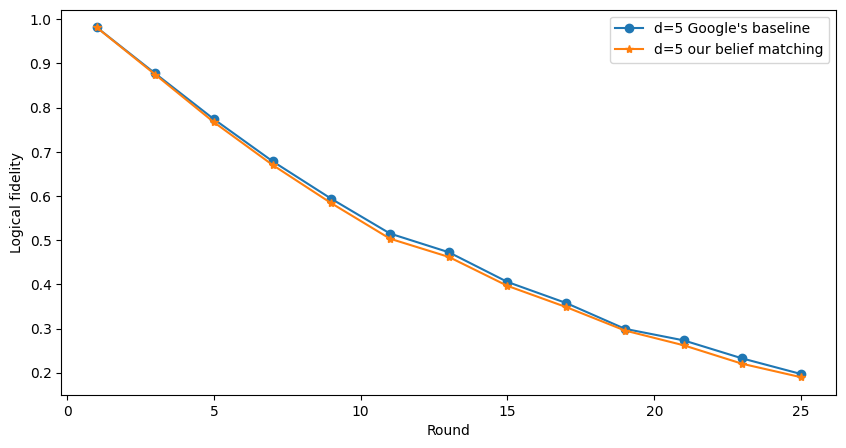

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(all_rounds, d5_baseline["belief_matching"], label="d=5 Google's baseline", marker='o')
ax.plot(all_rounds, beliefmatching_fidelities_d5, label="d=5 our belief matching", marker='*')
ax.set_xlabel("Round")
ax.set_ylabel("Logical fidelity")
ax.legend()
